# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn

import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

import torch
import torch.nn.functional as F
import botorch
import gpytorch

from src import molecules
from src.encoder import SelfiesEncoder
from src.vae import MolecularVAE
from src.loss import VAELoss
from src.train import train_model, TrainingConfig
from src.transforms import Standardizer, UnitCubeScaler

2023-08-20 11:55:36.058460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-20 11:55:36.739709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

# Preprocessing

Download raw dataset:

In [34]:
dataset_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

raw_df = pd.read_csv(dataset_url)
raw_df.to_csv(os.path.join("data", "qm9.csv"), index=False)

Add selfies encoding to raw data:

In [4]:
df = pd.read_csv(os.path.join("data", "qm9.csv"))

df["selfies"] = [sf.encoder(x, strict=False) for x in df.smiles]
df["logp"] = [molecules.penalized_logp(Chem.MolFromSmiles(s)) for s in df.smiles]

df.to_csv(os.path.join("data", "qm9_processed.csv"), index=False)

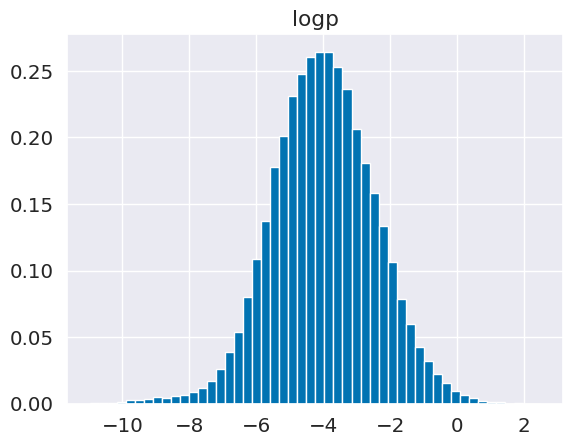

In [5]:
df.hist("logp", bins=50, density=True)
plt.show()

## Descriptors

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

In [8]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

sample_size = 1000
df_sample = df.sample(n=sample_size, random_state=12345)

In [9]:
excluded_names = ["MolLogP"]
available_names = [name for name, _ in Chem.Descriptors.descList if name not in excluded_names]

feature_selection_targets = ["alpha", "mu", "homo", "lumo", "gap", "r2", "zpve", "u0", "cv", "g298"]

In [10]:
descriptors = molecules.get_rdkit_descriptors(df_sample.smiles, names=available_names)
targets = df_sample[feature_selection_targets]

In [11]:
n_train = int(sample_size/2)

x = StandardScaler().fit_transform(descriptors)
x_train = x[:n_train]
x_test = x[n_train:]

y_train = targets[:n_train]
y_test = targets[n_train:]

In [12]:
rf = RandomForestRegressor(random_state=12345)
multi_rf = MultiOutputRegressor(rf)
multi_rf.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=12345))

In [13]:
mean_importances = np.mean([x.feature_importances_ for x in multi_rf.estimators_], axis=0)
mean_importances.shape

(208,)

In [14]:
n_features = [1, 2, 5, 10, 20, 40, 80, 160]
r2_vals = []
for nf in n_features:
    print(f"Evaluating model for n_features = {nf}")
    selected_support = mean_importances.argsort()[-nf:]
    x_train_selected = x_train[:, selected_support]
    x_test_selected = x_test[:, selected_support]

    # Use a new RF for each trial without a fixed seed
    estimator = MultiOutputRegressor(estimator=rf)
    estimator.fit(x_train_selected, y_train)
    y_hat = estimator.predict(x_test_selected)
    r2_vals.append(r2_score(y_test, y_hat))

Evaluating model for n_features = 1
Evaluating model for n_features = 2
Evaluating model for n_features = 5
Evaluating model for n_features = 10
Evaluating model for n_features = 20
Evaluating model for n_features = 40
Evaluating model for n_features = 80
Evaluating model for n_features = 160


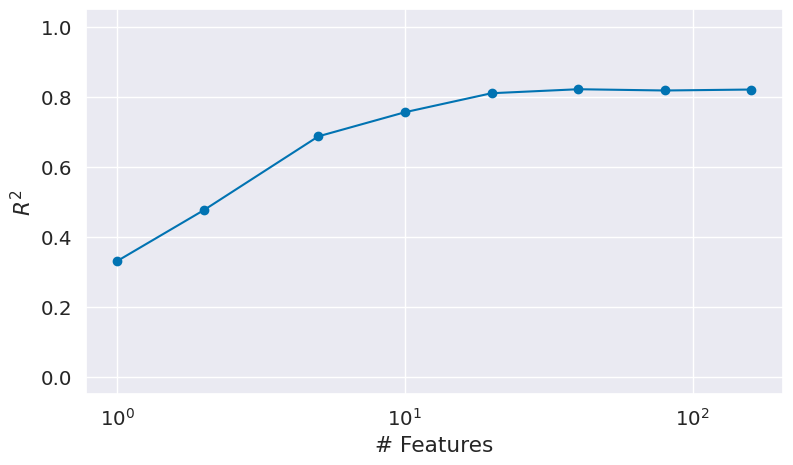

In [17]:
_, ax = plt.subplots(1, 1, figsize=(9, 5))

plt.plot(n_features, r2_vals, marker="o")

ax.set_xlabel("# Features")
ax.set_ylabel("$R^2$")
ax.set_ylim(-0.05, 1.05)
ax.set_xscale("log")

# plt.savefig("images/rdkit_feature_selection.png")
plt.show()

In [18]:
selected_indices = mean_importances.argsort()[-20:]
sorted([available_names[idx] for idx in selected_indices])

['BCUT2D_MRHI',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'FractionCSP3',
 'HallKierAlpha',
 'HeavyAtomMolWt',
 'Kappa1',
 'Kappa3',
 'LabuteASA',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MolMR',
 'NumRotatableBonds',
 'PEOE_VSA4',
 'TPSA',
 'VSA_EState2',
 'VSA_EState4',
 'VSA_EState5']

## Splits

In [21]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

selfies = df.selfies
selfies_encoder = SelfiesEncoder.build(selfies)

In [22]:
inputs = []
for s in tqdm(selfies):
    inputs.append(selfies_encoder.encode_one_hot(s))
inputs = torch.tensor(inputs)

inputs.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████| 133885/133885 [00:04<00:00, 31942.23it/s]


torch.Size([133885, 21, 29])

In [23]:
gap_target = df["gap"].to_numpy()
gap_target = (gap_target - gap_target.mean(axis=0)) / gap_target.std(axis=0)
gap_target = torch.from_numpy(gap_target)
gap_target = gap_target.reshape(-1, 1)

gap_target.shape

torch.Size([133885, 1])

In [24]:
logp_target = df["logp"].to_numpy()
logp_target = (logp_target - logp_target.mean(axis=0)) / logp_target.std(axis=0)
logp_target = torch.from_numpy(logp_target)
logp_target = logp_target.reshape(-1, 1)

logp_target.shape

torch.Size([133885, 1])

In [25]:
descriptor_names = [
    'BCUT2D_MRHI',
    'BertzCT',
    'Chi0',
    'Chi0n',
    'Chi0v',
    'FractionCSP3',
    'HallKierAlpha',
    'HeavyAtomMolWt',
    'Kappa1',
    'Kappa3',
    'LabuteASA',
    'MaxPartialCharge',
    'MinPartialCharge',
    'MolMR',
    'NumRotatableBonds',
    'PEOE_VSA4',
    'TPSA',
    'VSA_EState2',
    'VSA_EState4',
    'VSA_EState5'
]

mols = [Chem.MolFromSmiles(s) for s in df.smiles]

rdkit_descriptors = molecules.get_rdkit_descriptors(mols, names=descriptor_names)
rdkit_descriptors = (rdkit_descriptors - rdkit_descriptors.mean(axis=0)) / rdkit_descriptors.std(axis=0)
rdkit_descriptors = torch.from_numpy(rdkit_descriptors)

Split the data and save:

In [27]:
gen = torch.manual_seed(42)

n = len(inputs)
test_size = 15000
val_size = 2000
train_size = n - test_size - val_size

random_indices = torch.randperm(n, generator=gen)
train_indices = random_indices[:train_size]
test_indices = random_indices[train_size:train_size+test_size]
val_indices = random_indices[train_size+test_size:]

tensors = [
    ("inputs", inputs), 
    ("descriptors", rdkit_descriptors), 
    ("logp", logp_target), 
    ("gap", gap_target)
]
for name, tensor in tensors:
    train_tensor = tensor[train_indices]
    test_tensor = tensor[test_indices]
    val_tensor = tensor[val_indices]

    torch.save(train_tensor, os.path.join("data", f"qm9_{name}_train.pt"))
    torch.save(test_tensor, os.path.join("data", f"qm9_{name}_test.pt"))
    torch.save(val_tensor, os.path.join("data", f"qm9_{name}_val.pt"))

# Molecular VAE

## Training

In [56]:
config = TrainingConfig(
    targets="descriptors",
    epochs=100,
    lr_init=2e-3,
    lr_gamma=0.5,
    lr_milestones=[10, 20, 35, 50, 75],
    beta_max=1.0,
    beta_start=50,
    beta_end=75
)

config

TrainingConfig(targets='descriptors', epochs=100, latent_size=50, encoder_hidden_size=400, gru_hidden_size=500, mlp_hidden_size=300, gru_layers=3, gru_dropout=0.05, mse_scale=1.0, beta_max=1.0, beta_start=50, beta_end=75, lr_init=0.002, lr_gamma=0.5, lr_milestones=[10, 20, 35, 50, 75], weight_decay=1e-05, batch_size=250)

In [ ]:
train_model(config, run_name="descriptors_beta_1.0")

2023-08-20 13:13:12.703 | INFO     | src.train:train_model:119 - Using device cuda:0
2023-08-20 13:13:13.000 | INFO     | src.train:train_model:137 - Initialized model with 4039205 parameters


## Characterization

In [49]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

inputs_val = torch.load(os.path.join("data", "qm9_inputs_val.pt")).float()
descriptors_val = torch.load(os.path.join("data", "qm9_descriptors_val.pt")).float()

selfies = list(df.selfies)
selfies_encoder = SelfiesEncoder.build(selfies)

### Latent Distribution

In [50]:
#vae = vaes["100_constant"]
vae = mlflow.pytorch.load_model("mlflow-artifacts:/182501375824491979/5d56bf9a31834802a3666e451e8aff44/artifacts/model")
vae = vae.cpu().float()

In [52]:
z_means, z_logvars = vae.encode(inputs_val)
z_means = z_means.detach().numpy()
z_logvars = z_logvars.detach().numpy() 

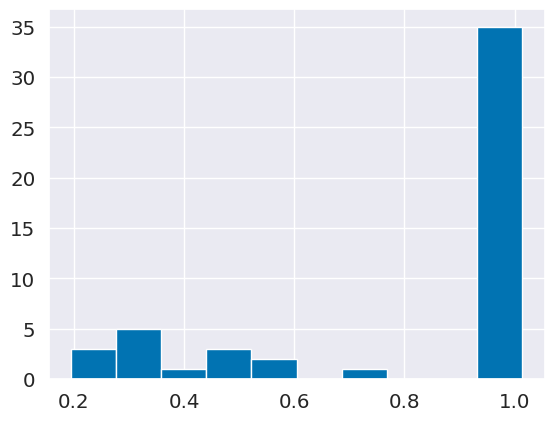

In [53]:
z_stds = np.sqrt(np.exp(z_logvars))
plt.hist(z_stds.mean(axis=0), bins=10)
plt.show()

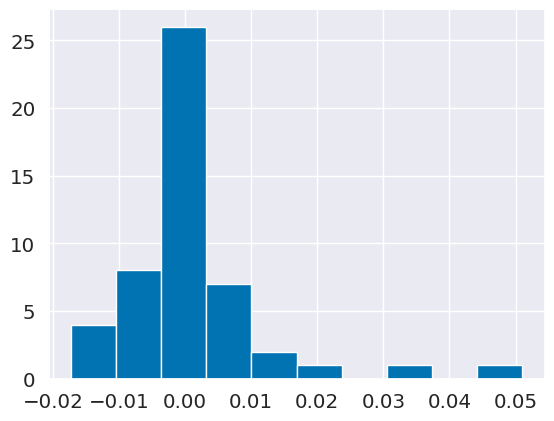

In [54]:
plt.hist(z_means.mean(axis=0), bins=10)

plt.show()

### Interpolation

In [92]:
start_selfie = sf.encoder("C")
end_selfie = sf.encoder("C(CC=O)C(CC=O)")

start_x = torch.tensor(selfies_encoder.encode_one_hot(start_selfie), dtype=torch.float32)
end_x = torch.tensor(selfies_encoder.encode_one_hot(end_selfie), dtype=torch.float32)

interp_x = vae.interpolate(start_x, end_x, 5)
interp_x = interp_x

interp_selfies = [selfies_encoder.decode_tensor(x) for x in interp_x]
interp_mols = [Chem.MolFromSmiles(sf.decoder(s)) for s in interp_selfies]

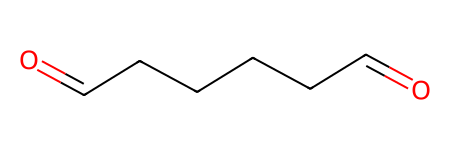

In [93]:
Chem.MolFromSmiles(sf.decoder(end_selfie))

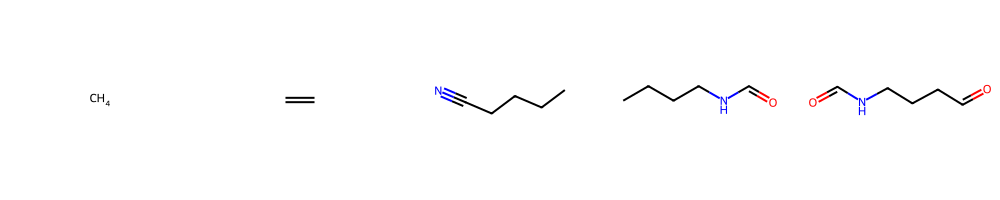

In [94]:
Chem.Draw.MolsToGridImage(interp_mols, molsPerRow=5)

### Regression

In [95]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

import umap

torch.manual_seed(145);

/home/sfriedowitz/miniconda3/envs/ssl/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sfriedowitz/miniconda3/envs/ssl/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sfriedowitz/miniconda3/envs/ssl/lib/python3.11/site-packag

In [97]:
inputs_val = torch.load(os.path.join("data", "qm9_inputs_val.pt")).float()
targets_val = torch.load(os.path.join("data", "qm9_targets_val.pt")).float()
descriptors_val = torch.load(os.path.join("data", "qm9_descriptors_val.pt")).float()
inputs_val.shape

torch.Size([2000, 21, 29])

In [98]:
selfies_sample = [selfies_encoder.decode_tensor(xi) for xi in inputs_val]
mols_sample = [Chem.MolFromSmiles(sf.decoder(s)) for s in selfies_sample]
target_sample = [molecules.penalized_logp(m) for m in mols_sample]

In [99]:
z = vae.encode(inputs_val)[0].detach().double()

y = torch.tensor(target_sample).view(-1, 1).double()

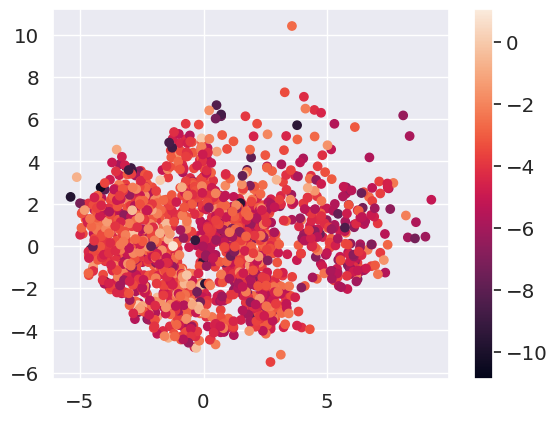

In [100]:
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=y)
plt.colorbar()

plt.show()

In [101]:
indices = torch.randperm(z.shape[0])

n_train = 500

ind_train = indices[:n_train]
ind_test = indices[n_train:]

z_train = z[ind_train]
z_test = z[ind_test]

y_train = y[ind_train]
y_test = y[ind_test]

input_scaler = UnitCubeScaler.build(z_train)
z_train_scaled = input_scaler.transform(z_train)
z_test_scaled = input_scaler.transform(z_test)

output_scaler = Standardizer.build(y_train)
y_train_scaled = output_scaler.transform(y_train)
y_test_scaled = output_scaler.transform(y_test)

In [102]:
gp = SingleTaskGP(z_train_scaled, y_train)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

mll = fit_gpytorch_mll(mll)

/home/sfriedowitz/miniconda3/envs/ssl/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-4.0041], dtype=torch.float64), std = tensor([1.5525], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [103]:
mvn = gp(z_test_scaled)

y_pred_mean = mvn.mean.detach()

In [104]:
r2_score(y_test, y_pred_mean)

0.41378018980875453

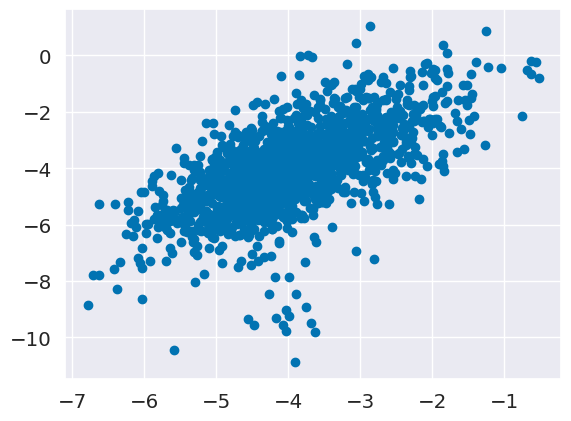

In [105]:
plt.scatter(y_pred_mean, y_test.flatten())

plt.show()